In [3]:
from medmnist import BloodMNIST
import torch

In [4]:
# Εισαγωγή βιβλιοθηκών για τυχαίους αριθμούς
import random
import numpy as np

# Συνάρτηση για ορισμό σταθερού seed σε όλες τις βιβλιοθήκες
def set_seed(seed=42):
    random.seed(seed)               # Ορισμός seed για τη βιβλιοθήκη random
    np.random.seed(seed)            # Ορισμός seed για τη βιβλιοθήκη numpy
    torch.manual_seed(seed)         # Ορισμός seed για CPU tensors του PyTorch
    torch.cuda.manual_seed(seed)    # Ορισμός seed για GPU tensors
    torch.cuda.manual_seed_all(seed)# Ορισμός seed για όλα τα GPU tensors (multi-GPU)

    # Διασφαλίζει deterministic συμπεριφορά σε CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Κλήση της συνάρτησης για να σταθεροποιήσουμε τα αποτελέσματα
set_seed(42)


In [5]:
# Φόρτωση του training dataset από το BloodMNIST
train_dataset = BloodMNIST(split="train", download=True)  # Κατεβάζει και φορτώνει τα δεδομένα εκπαίδευσης
X_train = train_dataset.imgs  # Αποθήκευση των εικόνων εκπαίδευσης σε μεταβλητή
y_train = train_dataset.labels  # Αποθήκευση των ετικετών/κλάσεων των εικόνων εκπαίδευσης

# Φόρτωση του test dataset από το BloodMNIST
test_dataset = BloodMNIST(split="test", download=True)  # Κατεβάζει και φορτώνει τα δεδομένα για δοκιμή
X_test = test_dataset.imgs  # Αποθήκευση των εικόνων δοκιμής σε μεταβλητή
y_test = test_dataset.labels  # Αποθήκευση των ετικετών των εικόνων δοκιμής

# Φόρτωση του validation dataset από το BloodMNIST
val_dataset = BloodMNIST(split="val", download=True)  # Κατεβάζει και φορτώνει τα δεδομένα επικύρωσης
X_val = val_dataset.imgs  # Αποθήκευση των εικόνων επικύρωσης σε μεταβλητή
y_val = val_dataset.labels  # Αποθήκευση των ετικετών των εικόνων επικύρωσης


In [6]:
# Ορισμός της συσκευής εκτέλεσης: χρησιμοποιούμε GPU αν υπάρχει, αλλιώς CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Εισαγωγή βασικών βιβλιοθηκών PyTorch και Matplotlib
import torch.nn as nn  # Βιβλιοθήκη για δημιουργία νευρωνικών δικτύων
import matplotlib  # Βασική βιβλιοθήκη για γραφικά/plotting
matplotlib.use("module://matplotlib_inline.backend_inline")  # Ρυθμίζει matplotlib για χρήση σε Jupyter Notebook
import matplotlib.pyplot as plt  # Υλοποίηση plotting (π.χ. γραφήματα, εικόνες)
import torch.optim as optimizer  # Εισαγωγή των optimizers για εκπαίδευση μοντέλων
import torch.nn.functional as F  # Εισαγωγή λειτουργιών που χρησιμοποιούνται σε layers (π.χ. activation functions)

# Αλλαγή διάστασης των εικόνων από (N, H, W, C) σε (N, C, H, W) για PyTorch
X_train = X_train.transpose(0, 3, 1, 2)  # Εκπαίδευση
X_test = X_test.transpose(0, 3, 1, 2)    # Δοκιμή
X_val = X_val.transpose(0, 3, 1, 2)      # Validation

# Μετατροπή των εικόνων σε PyTorch tensors και ορισμός τύπου δεδομένων float32
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)

# Μεταφορά των εικόνων στη σωστή συσκευή (GPU/CPU)
X_train = X_train.to(device)
X_test = X_test.to(device)
X_val = X_val.to(device)

# Μετατροπή των ετικετών σε PyTorch tensors τύπου long (απαραίτητο για cross-entropy loss)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)


In [7]:
# Εισαγωγή της βιβλιοθήκης torchvision για έτοιμα μοντέλα και εργαλεία computer vision
import torchvision

# Φόρτωση του προκαθορισμένου (pretrained) μοντέλου ResNet18
model = torchvision.models.resnet18(pretrained=True)  # Το μοντέλο έχει εκπαιδευτεί στο ImageNet

# Πάγωμα όλων των παραμέτρων του μοντέλου ώστε να μην εκπαιδεύονται
for param in model.parameters():
    param.requires_grad = False  # Απενεργοποιεί την ενημέρωση των weights κατά την εκπαίδευση


c:\Users\dimia\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dimia\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Τροποποίηση του τελικού fully connected (fc) layer του ResNet18
# Αντικαθιστούμε το τελευταίο layer με ένα custom multi-layer perceptron
model.fc = nn.Sequential(
    nn.Linear(512, 800),  # Πρώτο fully connected layer: 512 είσοδοι -> 800 έξοδοι
    nn.ReLU(),             # Λειτουργία ενεργοποίησης ReLU για μη γραμμικότητα
    nn.Linear(800, 72),   # Δεύτερο fully connected layer: 800 είσοδοι -> 72 έξοδοι
    nn.ReLU(),             # ReLU ενεργοποίηση
    nn.Linear(72, 8)       # Τελικό layer: 72 είσοδοι -> 8 κλάσεις (BloodMNIST έχει 8 τύπους κυττάρων)
)

# Μεταφορά του μοντέλου στη σωστή συσκευή (GPU/CPU)
model.to(device=device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Φόρτωση pretrained ResNet18
model2 = torchvision.models.resnet18(pretrained=True)

# Νέο τελικό layer για 8 κλάσεις BloodMNIST
model2.fc = nn.Linear(512, 8)

# Πάγωμα όλων των weights
for param in model2.parameters():
    param.requires_grad = False

# Fine-tuning μόνο στο τελευταίο residual block (layer4) και στο νέο fc layer
for param in model2.layer4.parameters():
    param.requires_grad = True
for param in model2.fc.parameters():
    param.requires_grad = True

# Μεταφορά μοντέλου σε GPU/CPU
model2.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# Ορισμός του optimizer Adam για εκπαίδευση μόνο των παραμέτρων του fc layer
optim_adam = optimizer.Adam(model.fc.parameters(), lr=0.001)

# Ορισμός υπερπαραμέτρων εκπαίδευσης
epochs = 20        # Αριθμός εποχών εκπαίδευσης
batch_size = 64    # Μέγεθος batch για training

# Ορισμός της συνάρτησης κόστους (loss) για multi-class classification
criterion = nn.CrossEntropyLoss()

# Ορισμός scheduler για προσαρμογή του learning rate όταν η απώλεια δεν βελτιώνεται
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optimizer=optim_adam,  # Ο optimizer που θα επηρεάσει
    mode='min',            # Παρακολουθούμε για μείωση της απώλειας
    factor=0.7,            # Ποσοστό μείωσης του learning rate
    patience=3,            # Αριθμός εποχών που περιμένει πριν μειώσει το lr
    threshold=0.007,       # Κατώφλι βελτίωσης
    min_lr=1e-6            # Ελάχιστο learning rate που θα φτάσει
)


In [11]:
# Ορισμός Adam optimizer για το fine-tuned μοντέλο (model2)
# Περιλαμβάνει μόνο τα αποπαγωμένα layers (layer4 + fc)
optim_adam2 = optimizer.Adam(model2.parameters(), lr=0.0005)  # Χαμηλότερο lr για fine-tuning

# Υπερπαράμετροι εκπαίδευσης για model2
epochs2 = 12       # Λιγότερες εποχές λόγω fine-tuning
batch_size2 = 32   # Μικρότερο batch size


In [12]:
def training_loop(Model, Optimizer, X_train, y_train, X_val, y_val, epochs, batch_size, criterion, scheduling):
    
    # Αποθήκευση ιστορικού
    history = []  # training loss
    val_loss_history = []  # validation loss
    accuracys_training = []  # training accuracy
    accuracys_validation = []  # validation accuracy
    n_samples = len(X_train)
    
    for epoch in range(epochs):
        permutation = torch.randperm(n_samples)  # τυχαία αναδιάταξη των δειγμάτων
        total_loss = 0

        # Training loop ανά batch
        for i in range(0, n_samples, batch_size):
            indices = permutation[i:i+batch_size]  # επιλέγουμε batch indices
            X_batch = X_train[indices]
            y_batch = y_train[indices]

            outputs = Model(X_batch)  # προώθηση μπροστά (forward pass)
            loss = criterion(outputs, y_batch[:,0])  # υπολογισμός loss
            Optimizer.zero_grad()  # μηδενισμός gradients
            loss.backward()  # backpropagation
            Optimizer.step()  # ενημέρωση weights

            total_loss += loss.item()  # συλλογή loss για το batch

        # Υπολογισμός ακρίβειας εκπαίδευσης
        with torch.no_grad():
            outputs_train = Model(X_train)
            predictions_train = torch.argmax(outputs_train, dim=1)
            accuracy_t = (predictions_train == y_train[:,0]).float().mean()

        # Υπολογισμός loss και ακρίβειας validation
        with torch.no_grad():
            outputs_val = Model(X_val)
            val_loss = criterion(outputs_val, y_val[:,0]).item()
            predictions_val = torch.argmax(outputs_val, dim=1)
            accuracy_v = (predictions_val == y_val[:,0]).float().mean()
            
        # Scheduler: προσαρμογή learning rate αν υπάρχει
        if scheduling is not None:
            scheduling.step(val_loss)

        # Αποθήκευση ιστορικού
        history.append(total_loss / (n_samples // batch_size))
        val_loss_history.append(val_loss)
        accuracys_training.append(accuracy_t.item())
        accuracys_validation.append(accuracy_v.item())

        # Εκτύπωση αποτελεσμάτων για κάθε εποχή
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {history[-1]:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {accuracy_t:.4f}, Val Acc: {accuracy_v:.4f}")

    # Επιστροφή ιστορικών για plot ή ανάλυση
    return history, val_loss_history, accuracys_training, accuracys_validation



In [13]:
history2,val_loss2,accracys_training2,accracys_validation2=training_loop(Model=model2,Optimizer=optim_adam2,X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val,epochs=epochs2,batch_size=batch_size2,criterion=criterion,scheduling=None)

Epoch [1/12], Loss: 0.6670, Val Loss: 0.4097, Train Acc: 0.8961, Val Acc: 0.8534
Epoch [2/12], Loss: 0.4116, Val Loss: 0.3584, Train Acc: 0.9351, Val Acc: 0.8703
Epoch [3/12], Loss: 0.3417, Val Loss: 0.3429, Train Acc: 0.9515, Val Acc: 0.8773
Epoch [4/12], Loss: 0.2849, Val Loss: 0.3532, Train Acc: 0.9550, Val Acc: 0.8803
Epoch [5/12], Loss: 0.2513, Val Loss: 0.3587, Train Acc: 0.9740, Val Acc: 0.8791
Epoch [6/12], Loss: 0.2074, Val Loss: 0.3754, Train Acc: 0.9632, Val Acc: 0.8744
Epoch [7/12], Loss: 0.1820, Val Loss: 0.3855, Train Acc: 0.9803, Val Acc: 0.8820
Epoch [8/12], Loss: 0.1722, Val Loss: 0.3567, Train Acc: 0.9865, Val Acc: 0.8843
Epoch [9/12], Loss: 0.1555, Val Loss: 0.3393, Train Acc: 0.9909, Val Acc: 0.8919
Epoch [10/12], Loss: 0.1344, Val Loss: 0.4196, Train Acc: 0.9877, Val Acc: 0.8715
Epoch [11/12], Loss: 0.1251, Val Loss: 0.3824, Train Acc: 0.9911, Val Acc: 0.8855
Epoch [12/12], Loss: 0.1174, Val Loss: 0.4081, Train Acc: 0.9921, Val Acc: 0.8768


In [14]:
history,val_loss,accracys_training,accracys_validation=training_loop(Model=model,Optimizer=optim_adam,X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val,epochs=epochs,batch_size=batch_size,criterion=criterion,scheduling=scheduler)

Epoch [1/20], Loss: 1.0587, Val Loss: 0.8345, Train Acc: 0.7006, Val Acc: 0.6828
Epoch [2/20], Loss: 0.8178, Val Loss: 0.7402, Train Acc: 0.7572, Val Acc: 0.7284
Epoch [3/20], Loss: 0.7684, Val Loss: 0.7407, Train Acc: 0.7624, Val Acc: 0.7360
Epoch [4/20], Loss: 0.7299, Val Loss: 0.7271, Train Acc: 0.7844, Val Acc: 0.7488
Epoch [5/20], Loss: 0.6917, Val Loss: 0.6825, Train Acc: 0.7966, Val Acc: 0.7588
Epoch [6/20], Loss: 0.6615, Val Loss: 0.7258, Train Acc: 0.8046, Val Acc: 0.7453
Epoch [7/20], Loss: 0.6437, Val Loss: 0.7493, Train Acc: 0.7791, Val Acc: 0.7208
Epoch [8/20], Loss: 0.6242, Val Loss: 0.6950, Train Acc: 0.8151, Val Acc: 0.7471
Epoch [9/20], Loss: 0.6136, Val Loss: 0.7315, Train Acc: 0.8050, Val Acc: 0.7371
Epoch [10/20], Loss: 0.5466, Val Loss: 0.7074, Train Acc: 0.8345, Val Acc: 0.7383
Epoch [11/20], Loss: 0.5250, Val Loss: 0.6774, Train Acc: 0.8663, Val Acc: 0.7687
Epoch [12/20], Loss: 0.5265, Val Loss: 0.6817, Train Acc: 0.8630, Val Acc: 0.7500
Epoch [13/20], Loss: 0.50

In [15]:
import numpy as np

def metrics(model, X_test, y_test):
    
    model.eval()  # Θέτουμε το μοντέλο σε evaluation mode
    accuracy_test = 0
    num_classes = 8  # BloodMNIST έχει 8 κλάσεις

    with torch.no_grad():  # Δεν χρειάζονται gradients
        outputs = model(X_test)  # Προβλέψεις
        predictions = torch.argmax(outputs, dim=1)  # Επιλογή κλάσης με μέγιστη πιθανότητα
        accuracy_test = (predictions == y_test[:,0]).float().mean()  # Συνολική ακρίβεια

    # Δημιουργία confusion matrix
    confusion_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int32)

    # Γέμισμα πίνακα: γραμμές = true labels, στήλες = predicted labels
    for i in range(len(y_test)):
        true_label = int(y_test[i, 0])
        pred_label = int(predictions[i])
        confusion_matrix[true_label, pred_label] += 1

    # Μετατροπή σε numpy για υπολογισμό metrics
    cm1 = confusion_matrix.numpy()
    cm = confusion_matrix.numpy().astype(float)

    # Αρχικοποίηση arrays για precision, recall, f1
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)

    # Υπολογισμός metrics ανά κλάση
    for i in range(num_classes):
        TP = cm[i, i]  # true positives
        FP = cm[:, i].sum() - TP  # false positives
        FN = cm[i, :].sum() - TP  # false negatives

        precision[i] = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

    # Εμφάνιση metrics ανά κλάση
    for i in range(num_classes):
        print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}")

    return accuracy_test, cm1


Class 0: Precision=0.868, Recall=0.725, F1=0.790
Class 1: Precision=0.963, Recall=0.971, F1=0.967
Class 2: Precision=0.919, Recall=0.797, F1=0.854
Class 3: Precision=0.735, Recall=0.820, F1=0.776
Class 4: Precision=0.795, Recall=0.909, F1=0.848
Class 5: Precision=0.718, Recall=0.725, F1=0.722
Class 6: Precision=0.958, Recall=0.926, F1=0.942
Class 7: Precision=0.996, Recall=0.981, F1=0.988
Test Accuracy: 88.02%


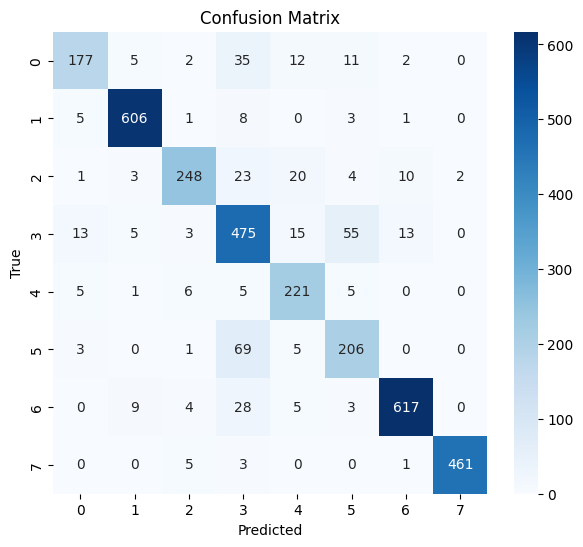

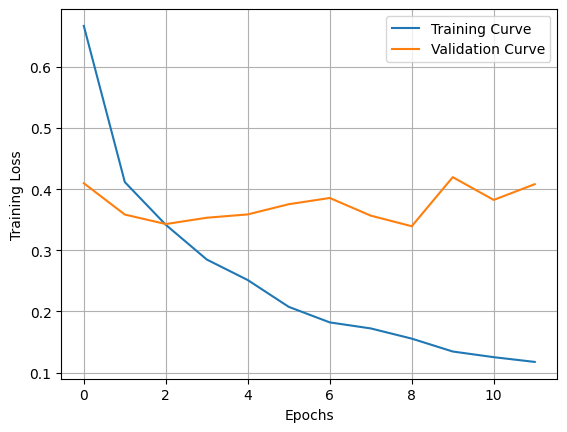

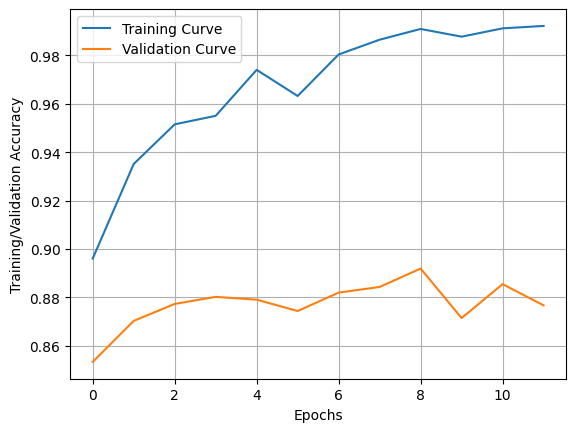

In [16]:
import seaborn as sns

# Υπολογισμός metrics για το μοντέλο model2 (fine-tuning) στο test set
accuracy_score2, cm2 = metrics(model2, X_test, y_test)
print(f"Test Accuracy: {accuracy_score2 * 100:.2f}%")  # Εκτύπωση συνολικής ακρίβειας

# Σχεδίαση confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues")  # Annot=True εμφανίζει αριθμούς
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot training & validation loss
plt.figure()
plt.plot(history2)      # training loss
plt.plot(val_loss2)     # validation loss
plt.legend(['Training Curve','Validation Curve'])
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()

# Plot training & validation accuracy
plt.figure()
plt.plot(accracys_training2)      # training accuracy
plt.plot(accracys_validation2)    # validation accuracy
plt.legend(['Training Curve','Validation Curve'])
plt.xlabel('Epochs')
plt.ylabel('Training/Validation Accuracy')
plt.grid(True)
plt.show()


Class 0: Precision=0.584, Recall=0.582, F1=0.583
Class 1: Precision=0.927, Recall=0.921, F1=0.924
Class 2: Precision=0.693, Recall=0.617, F1=0.653
Class 3: Precision=0.553, Recall=0.672, F1=0.607
Class 4: Precision=0.740, Recall=0.679, F1=0.708
Class 5: Precision=0.567, Recall=0.342, F1=0.426
Class 6: Precision=0.796, Recall=0.859, F1=0.826
Class 7: Precision=0.944, Recall=0.934, F1=0.939
Test Accuracy: 75.15%


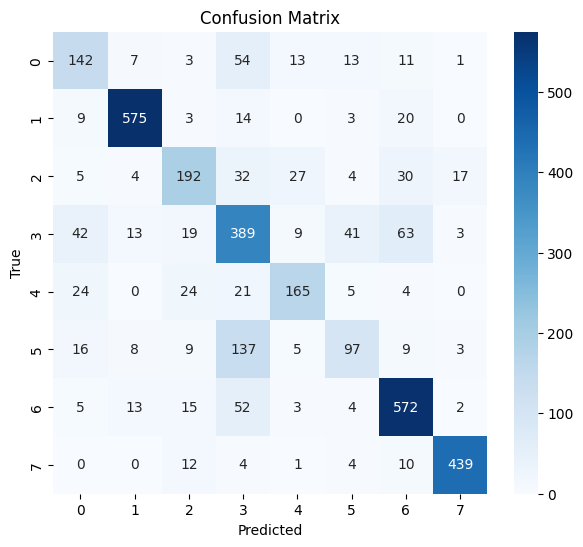

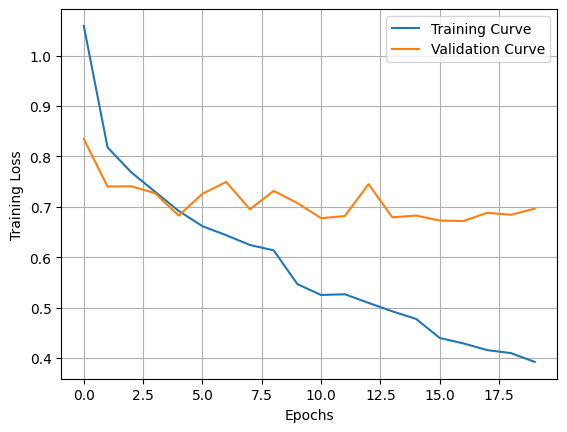

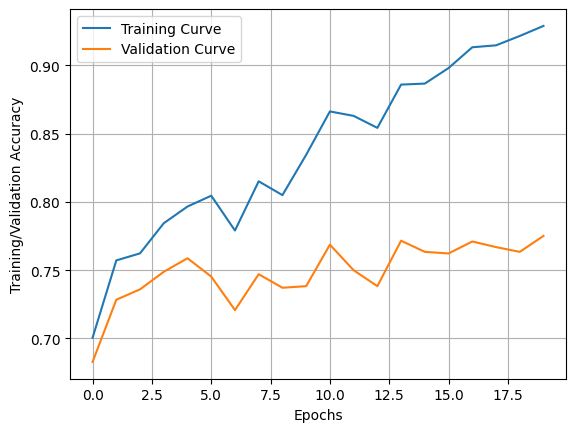

In [17]:


# Υπολογισμός metrics για το μοντέλο model (feature extraction) στο test set
accuracy_score, cm = metrics(model, X_test, y_test)
print(f"Test Accuracy: {accuracy_score * 100:.2f}%")  # Εκτύπωση συνολικής ακρίβειας

# Σχεδίαση confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # Annot=True εμφανίζει αριθμούς
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot training & validation loss
plt.figure()
plt.plot(history)      # training loss
plt.plot(val_loss)     # validation loss
plt.legend(['Training Curve','Validation Curve'])
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()

# Plot training & validation accuracy
plt.figure()
plt.plot(accracys_training)      # training accuracy
plt.plot(accracys_validation)    # validation accuracy
plt.legend(['Training Curve','Validation Curve'])
plt.xlabel('Epochs')
plt.ylabel('Training/Validation Accuracy')
plt.grid(True)
plt.show()